<h1>Приложение 1</h1>

<h2>1. Подсчёт метрик коллокационной силы Mutual Information и Lexical Gravity, их корреляции для выборки корпуса REALEC</h2>

Рассматривалась выборка неповторяющихся текстов, не содержащих значения "graph description" в поле "type" метаданных (1859 текстов, 506 579 слов).

In [2]:
import sqlite3, pandas, scipy.stats

Откроем составленную базу данных и файл с SQL-скриптом:

In [2]:
db = sqlite3.connect('P:/Studies/2nd-year-thesis/realec_database.db')

with open ('P:/Studies/2nd-year-thesis/get_full_table.sql','r',encoding='utf-8') as source:
    query = source.read().split(';')

Выполним содержащиеся в скрипте запросы к базе данных:

In [4]:
c = db.cursor()

for statement in query:
    c.execute(statement)
    
db.commit()

Запишем полученные сводные таблицы в объекты pandas: bigrams - для биграмм, составленных
из словоформ; lemma_bigrams - для биграмм, составленных из лемм, выделенных парсером udpipe (Биграммы выделялись только в пределах границ предложений, как в работе Гриса).

In [3]:
bigrams = pandas.read_sql('SELECT * FROM bigrams_with_freqs3 WHERE frequency>0',db)

In [6]:
lemma_bigrams = pandas.read_sql('SELECT * FROM lemma_bigrams_with_freqs1 WHERE frequency>0',db)

Найдём значения <b>метрики MI</b> для биграмм:

In [4]:
import math

N = list(db.execute('SELECT SUM(Frequency) FROM wordforms;'))[0][0]
bigrams['MI'] = bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)

In [9]:
lemma_bigrams['MI'] = lemma_bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)

In [10]:
db.close()

Теперь найдём значения <b>метрики Lexical Gravity</b> (G-score):

In [11]:
form_typesafter = bigrams['id_wordform1'].value_counts()
form_typesbefore = bigrams['id_wordform2'].value_counts()

lemma_typesafter = lemma_bigrams['id_lemma1'].value_counts()
lemma_typesbefore = lemma_bigrams['id_lemma2'].value_counts()

In [52]:
bigrams['G-score'] = bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                   math.log(form_typesafter[x['id_wordform1']],2)+
                                   math.log(form_typesbefore[x['id_wordform2']],2),axis = 1)

lemma_bigrams['G-score'] = lemma_bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                  math.log(lemma_typesafter[x['id_lemma1']],2)+
                                  math.log(lemma_typesbefore[x['id_lemma2']],2),axis = 1)

Найдём линейные парные <b>коэффициенты корреляции Пирсона</b> для частоты и метрик MI и Lexical Gravity:

In [37]:
correlations = bigrams.corr(method='pearson').drop(labels=['id','id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id','id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.034118,0.410988
MI,-0.034118,1.000000,0.242665
G-score,0.410988,0.242665,1.000000


In [38]:
lemma_correlations = lemma_bigrams.corr(method='pearson').drop(labels=['id','id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id','id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.032521,0.401216
MI,-0.032521,1.000000,0.237638
G-score,0.401216,0.237638,1.000000


Проверим полученные коэффициенты корреляции на значимость.  Для этого проверим гипотезу о том, что все коэффициенты корреляции равны нулю  при помощи <i>t</i>-теста Стьюдента.Пороговый
уровень значимости установим <i>a</i> = 0.05:

In [39]:
count_t_score = lambda x, n: x*((n-2)**0.5)/((1-x**2)**0.5)
p_value = lambda x, n: (1-scipy.stats.t.cdf(count_t_score(x,n),n-2))*2

n1 = len(bigrams.index)

correlations.applymap(lambda x: p_value(abs(x),n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [41]:
n2 = len(lemma_bigrams.index)

lemma_correlations.applymap(lambda x: p_value(abs(x),n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Нулевая гипотеза отвергается для всех коэффициентов корреляции, поэтому все из них можно считать значимыми

Теперь найдём <b>ранговые коэффициенты корреляции Спирмена и Кендалла</b>.

Найдём <b>коэффициент Спирмена</b>:

In [42]:
correlations = bigrams.corr(method='spearman').drop(labels=['id','id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id','id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.253792,0.655171
MI,-0.253792,1.000000,0.376502
G-score,0.655171,0.376502,1.000000


In [43]:
lemma_correlations = lemma_bigrams.corr(method='spearman').drop(labels=['id','id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id','id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.266710,0.668379
MI,-0.266710,1.000000,0.365353
G-score,0.668379,0.365353,1.000000


Проверим гипотезу о равенстве полученных коэффициентов нулю:

In [44]:
center_and_normalize = lambda x,n: x*((n-1)**0.5)

p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [45]:
lemma_correlations.applymap(lambda x: p_value(x,n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Здесь также нулевая гипотеза для всех значений отвергается.

Найдём <b>коэффициент Кенделла</b>:

In [27]:
correlations = bigrams.corr(method='kendall').drop(labels=['id','id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id','id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.195629,0.544461
MI,-0.195629,1.000000,0.281723
G-score,0.544461,0.281723,1.000000


In [28]:
lemma_correlations = lemma_bigrams.corr(method='kendall').drop(labels=['id','id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id','id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.204738,0.556201
MI,-0.204738,1.000000,0.274059
G-score,0.556201,0.274059,1.000000


Проверим на значимость:

In [47]:
center_and_normalize = lambda x,n: x*(((9*(n**2)-9*n)/(10*n+10))**0.5)
p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [48]:
lemma_correlations.applymap(lambda x: p_value(x,n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Все коэффициенты проходят проверку на значимость, так как вероятность истинности нулевой гипотезы настолько стремится
к нулю, что не помещается полностью в переменную типа float

Сохраним полученные значения метрик колллокационной силы вместе с таблицами биграмм:

In [19]:
bigrams.to_csv('realec_bigrams.csv')
lemma_bigrams.to_csv('realec_lemma_bigrams.csv')

Теперь посмотрим ранговую корреляцию для биграмм, у которых частота >= 2:

In [1]:
cut_by_threshold = lambda df, threshold: df.loc[df['frequency'] >= threshold]

In [21]:
bigrams = cut_by_threshold(pandas.read_csv('realec_bigrams.csv',index_col='id',encoding='ansi'),2)

Найдём <b>коэффициент Кенделла</b>:

In [22]:
correlations = bigrams.corr(method='kendall').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.012774,0.699127
MI,-0.012774,1.000000,0.210920
G-score,0.699127,0.210920,1.000000


Найдём <b>коэффициент Спирмена</b>:

In [23]:
correlations = bigrams.corr(method='spearman').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.018812,0.836408
MI,-0.018812,1.000000,0.309339
G-score,0.836408,0.309339,1.000000


<h2>2. Подсчёт метрик коллокационной силы Mutual Information и Lexical Gravity, их корреляции для подкорпуса LOCNESS A-Levels</h2>

Рассматривались только тексты подкорпуса A-Levels (115 текстов, 60 209 слов).

Откроем составленную базу данных и файл с SQL-скриптом:

In [25]:
import pandas, math, sqlite3

db = sqlite3.connect('P:/Studies/2nd-year-thesis/locness_alevels_database.db')

with open ('P:/Studies/2nd-year-thesis/get_full_table.sql','r',encoding='utf-8') as source:
    query = source.read().split(';')

Выполним содержащиеся в скрипте запросы к базе данных:

In [26]:
c = db.cursor()

for statement in query:
    c.execute(statement)
    
db.commit()

Запишем полученные сводные таблицы в объекты pandas: bigrams - для биграмм, составленных
из словоформ; lemma_bigrams - для биграмм, составленных из лемм, выделенных парсером udpipe (Биграммы выделялись только в пределах границ предложений, как в работе Гриса).

In [27]:
bigrams = pandas.read_sql('SELECT * FROM bigrams_with_freqs3 WHERE frequency>0',index_col='id',db)

In [21]:
lemma_bigrams = pandas.read_sql('SELECT * FROM lemma_bigrams_with_freqs1 WHERE frequency>0',index_col='id',db)

Найдём значения <b>метрики MI</b> для биграмм:

In [7]:
import math

N = list(db.execute('SELECT SUM(Frequency) FROM wordforms;'))[0][0]
bigrams['MI'] = bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)

In [8]:
lemma_bigrams['MI'] = lemma_bigrams.apply(lambda x: math.log(x['frequency'],
                                                 2)+math.log(N,2)-math.log(x['frequency:1'],2)
                              -math.log(x['frequency:2'],2),
                              axis=1)

In [9]:
db.close()

Теперь найдём значения <b>метрики Lexical Gravity</b> (G-score):

In [22]:
form_typesafter = bigrams['id_wordform1'].value_counts()
form_typesbefore = bigrams['id_wordform2'].value_counts()

lemma_typesafter = lemma_bigrams['id_lemma1'].value_counts()
lemma_typesbefore = lemma_bigrams['id_lemma2'].value_counts()

In [11]:
bigrams['G-score'] = bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                   math.log(form_typesafter[x['id_wordform1']],2)+
                                   math.log(form_typesbefore[x['id_wordform2']],2),axis = 1)

lemma_bigrams['G-score'] = lemma_bigrams.apply(lambda x: x['MI']-math.log(N,2)+math.log(x['frequency'],2)+
                                  math.log(lemma_typesafter[x['id_lemma1']],2)+
                                  math.log(lemma_typesbefore[x['id_lemma2']],2),axis = 1)

In [29]:
##"каноническая" функция Lexical Gravity для проверки:
bigrams['G-score'] = bigrams.apply(lambda x: 2*math.log(x['frequency'],2)-
                                   math.log(x['frequency:1'],2)-
                                   math.log(x['frequency:2'],2)+
                                   math.log(form_typesafter[x['id_wordform1']],2)+
                                   math.log(form_typesbefore[x['id_wordform2']],2),axis = 1)

lemma_bigrams['G-score'] = lemma_bigrams.apply(lambda x: 2*math.log(x['frequency'],2)-
                                               math.log(x['frequency:1'],2)-
                                               math.log(x['frequency:2'],2)+
                                  math.log(lemma_typesafter[x['id_lemma1']],2)+
                                  math.log(lemma_typesbefore[x['id_lemma2']],2),axis = 1)

Найдём линейные парные <b>коэффициенты корреляции Пирсона</b> для частоты и метрик MI и Lexical Gravity:

In [18]:
correlations = bigrams.corr(method='pearson').drop(labels=['id','id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id','id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.089175,0.530761
MI,-0.089175,1.000000,0.165888
G-score,0.530761,0.165888,1.000000


In [19]:
lemma_correlations = lemma_bigrams.corr(method='pearson').drop(labels=['id','id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id','id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.089568,0.535339
MI,-0.089568,1.000000,0.164081
G-score,0.535339,0.164081,1.000000


Проверим полученные коэффициенты корреляции на значимость.  Для этого проверим гипотезу о том, что все коэффициенты корреляции равны нулю  при помощи <i>t</i>-теста Стьюдента.Пороговый
уровень значимости установим <i>a</i> = 0.05:

In [20]:
import scipy.stats

count_t_score = lambda x, n: x*((n-2)**0.5)/((1-x**2)**0.5)
p_value = lambda x, n: (1-scipy.stats.t.cdf(count_t_score(x,n),n-2))*2

n1 = len(bigrams.index)

correlations.applymap(lambda x: p_value(abs(x),n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [21]:
n2 = len(lemma_bigrams.index)

lemma_correlations.applymap(lambda x: p_value(abs(x),n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Нулевая гипотеза отвергается для всех коэффициентов корреляции, поэтому все из них можно считать значимыми

Теперь найдём <b>ранговые коэффициенты корреляции Спирмена и Кендалла</b>.

Найдём <b>коэффициент Спирмена</b>:

In [22]:
correlations = bigrams.corr(method='spearman').drop(labels=['id','id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id','id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.248543,0.627288
MI,-0.248543,1.000000,0.354278
G-score,0.627288,0.354278,1.000000


In [23]:
lemma_correlations = lemma_bigrams.corr(method='spearman').drop(labels=['id','id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id','id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.260243,0.648974
MI,-0.260243,1.000000,0.340307
G-score,0.648974,0.340307,1.000000


Проверим гипотезу о равенстве полученных коэффициентов нулю:

In [26]:
center_and_normalize = lambda x,n: x*((n-1)**0.5)

p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [27]:
lemma_correlations.applymap(lambda x: p_value(x,n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Здесь также нулевая гипотеза для всех значений отвергается.

Найдём <b>коэффициент Кенделла</b>:

In [28]:
correlations = bigrams.corr(method='kendall').drop(labels=['id','id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id','id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.196613,0.522275
MI,-0.196613,1.000000,0.271354
G-score,0.522275,0.271354,1.000000


In [29]:
lemma_correlations = lemma_bigrams.corr(method='kendall').drop(labels=['id','id_lemma1','frequency:1','frequency:2',
                                           'id_lemma2']).drop(labels=['id','id_lemma1',
                                                                      'frequency:1',
                                                                      'frequency:2',
                                                                      'id_lemma2'],axis=1)
lemma_correlations

,frequency,MI,G-score
frequency,1.000000,-0.204852,0.541571
MI,-0.204852,1.000000,0.263080
G-score,0.541571,0.263080,1.000000


Проверим на значимость:

In [30]:
center_and_normalize = lambda x,n: x*(((9*(n**2)-9*n)/(10*n+10))**0.5)
p_value = lambda x,n: (1-scipy.stats.norm.cdf(center_and_normalize(abs(x),n)))*2

correlations.applymap(lambda x: p_value(x,n1) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


In [31]:
lemma_correlations.applymap(lambda x: p_value(x,n2) if x!=1 else 0)

,frequency,MI,G-score
frequency,0.0,0.0,0.0
MI,0.0,0.0,0.0
G-score,0.0,0.0,0.0


Все коэффициенты проходят проверку на значимость, так как вероятность истинности нулевой гипотезы настолько стремится
к нулю, что не помещается полностью в переменную типа float

In [11]:
bigrams.to_csv('locness_alevels_bigrams.csv')
lemma_bigrams.to_csv('locness_alevels_lemma_bigrams.csv')

Теперь посмотрим ранговую корреляцию для биграмм, у которых частота >= 2:

In [1]:
cut_by_threshold = lambda df, threshold: df.loc[df['frequency'] >= threshold]

In [12]:
bigrams = cut_by_threshold(pandas.read_csv('locness_alevels_bigrams.csv',index_col='id',encoding='ansi'),2)

Найдём <b>коэффициент Кенделла</b>:

In [13]:
correlations = bigrams.corr(method='kendall').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.079463,0.698648
MI,-0.079463,1.000000,0.065015
G-score,0.698648,0.065015,1.000000


Найдём <b>коэффициент Спирмена</b>:

In [14]:
correlations = bigrams.corr(method='spearman').drop(labels=['id_wordform1','frequency:1',
                                           'frequency:2','id_wordform2']).drop(labels=['id_wordform1',
                                                                                       'frequency:1',
                                                                                       'frequency:2',
                                                                                       'id_wordform2'],axis=1)
correlations

,frequency,MI,G-score
frequency,1.000000,-0.107043,0.827896
MI,-0.107043,1.000000,0.097857
G-score,0.827896,0.097857,1.000000


<h2>3. Анализ распределения метрик для корпусов</h2>

In [1]:
import pandas, math
import matplotlib.pyplot as plt

realec_bigrams = pandas.read_csv('realec_bigrams.csv')
realec_lemma_bigrams = pandas.read_csv('realec_lemma_bigrams.csv',encoding='ansi')
alevels_bigrams = pandas.read_csv('locness_alevels_bigrams.csv', encoding='ansi')
alevels_lemma_bigrams = pandas.read_csv('locness_alevels_lemma_bigrams.csv', encoding='ansi')

Так как у нас получились большие коэффициенты корреляции для частоты биграммы и её значения Lexical Gravity, посмотрим на эту взаимосвязь на графике:

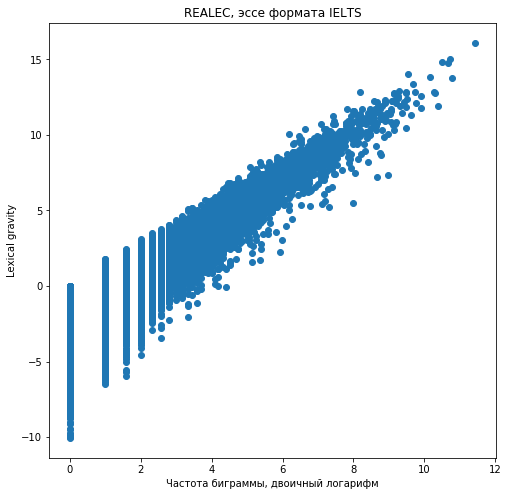

In [2]:
plt.figure(figsize=(8,8))
plt.scatter(realec_bigrams['frequency'].apply(lambda x: math.log(x,2)),realec_bigrams['G-score'])
plt.xlabel('Частота биграммы, двоичный логарифм')
plt.ylabel('Lexical gravity')
plt.title('REALEC, эссе формата IELTS')
plt.savefig('figures/realec_essays_frequency_gravity_corr.png',bbox_inches='tight')
plt.show()

In [5]:
realec_bigrams['G-score'].corr(realec_bigrams['frequency'].apply(lambda x: math.log(x,2)))

0.8450585936192873

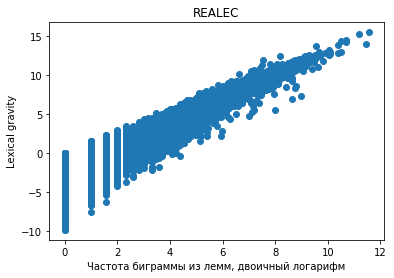

In [39]:
plt.scatter(realec_lemma_bigrams['frequency'].apply(lambda x: math.log(x,2)),realec_lemma_bigrams['G-score'])
plt.xlabel('Частота биграммы из лемм, двоичный логарифм')
plt.ylabel('Lexical gravity')
plt.title('REALEC')
plt.show()

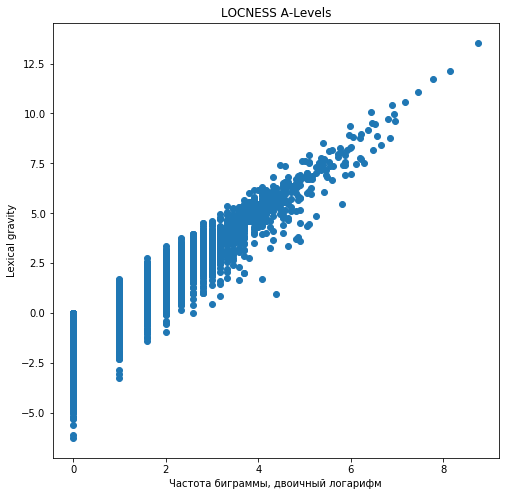

In [3]:
plt.figure(figsize=(8,8))
plt.scatter(alevels_bigrams['frequency'].apply(lambda x: math.log(x,2)),alevels_bigrams['G-score'])
plt.xlabel('Частота биграммы, двоичный логарифм')
plt.ylabel('Lexical gravity')
plt.title('LOCNESS A-Levels')
plt.savefig('figures/locness_alevels_frequency_gravity_corr.png',bbox_inches='tight')
plt.show()

In [6]:
alevels_bigrams['G-score'].corr(alevels_bigrams['frequency'].apply(lambda x: math.log(x,2)))

0.8437704613235986

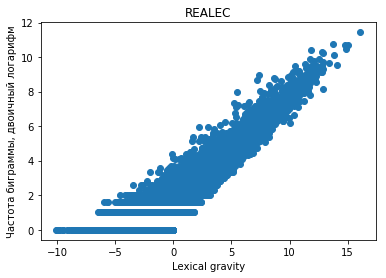

In [43]:
plt.scatter(realec_bigrams['G-score'],realec_bigrams['frequency'].apply(lambda x: math.log(x,2)))
plt.ylabel('Частота биграммы, двоичный логарифм')
plt.xlabel('Lexical gravity')
plt.title('REALEC')
plt.show()

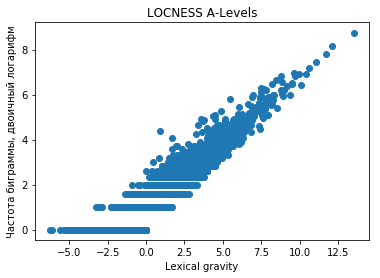

In [44]:
plt.scatter(alevels_bigrams['G-score'],alevels_bigrams['frequency'].apply(lambda x: math.log(x,2)))
plt.ylabel('Частота биграммы, двоичный логарифм')
plt.xlabel('Lexical gravity')
plt.title('LOCNESS A-Levels')
plt.show()